## Подготовка данных

Загружаем библиотеки

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
import time

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

Загружаем файл и смотрим информацию

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
data.columns = data.columns.str.lower() # переводим названия столбцов в нижний регистр

In [5]:
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


проверим на дубликаты и удалим их

In [6]:
data.duplicated().sum() 

4

In [7]:
data = data.drop_duplicates()

удаляем столбцы   
'numberofpictures' в столбце только одни нули  
'datecreated' дата создания анкеты, ни какой информации для обучения модели не несет  
'postalcode' почтовый индекс владельца так же безполезен  
'lastseen' дата последней активности пользователя, на цену автомобиля ни как не влияет  
'datecrawled' дата скачивания анкеты из базы, ни как не изменит стоимость автомобиля  
'registrationyear', 'registrationmonth' год и месяц регистрации, не поможет нам ни как, так как автомобиль может перерегистрироваться, и точный возраст авто не узнать

In [8]:
data = data.drop(['datecreated', 'postalcode', 'lastseen', 'numberofpictures', 'datecrawled', 'registrationyear', 'registrationmonth'], axis=1)

отсеиваем столбцы с нулевой стоимостью, но при этом оставляем столбцы с ценой более 1 евро, так как такая цена может быть, в европе стоимость утилизации может быть дороже рыночной стоимости автомобиля, и поэтому бывает что машины продают за 1 евро

In [9]:
data = data[data['price'] != 0]

In [10]:
data.isna().sum() #смотрим пропуски

price              0
vehicletype    33750
gearbox        17355
power              0
model          17521
kilometer          0
fueltype       29459
brand              0
notrepaired    65866
dtype: int64

In [11]:
data['gearbox'].value_counts()

manual    261371
auto       64867
Name: gearbox, dtype: int64

кроме механических и автоматических кпп, есть и другие типы кпп, поэтому заменим пропуски на 'other'

In [12]:
data['gearbox'] = data['gearbox'].fillna('other')

In [13]:
data['model'].value_counts()

golf                  28246
other                 23706
3er                   19179
polo                  12628
corsa                 12197
                      ...  
i3                        8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: model, Length: 250, dtype: int64

так же заполним и по пропускам в моделях, по косвенным признакам может определить модель, но это будет не точно 

In [14]:
data['model'] = data['model'].fillna('other')

In [15]:
data['fueltype'].value_counts()

petrol      210762
gasoline     97167
lpg           5166
cng            554
hybrid         227
other          170
electric        88
Name: fueltype, dtype: int64

до подлино выяснить тип топлива, не представляется возможным, поэтому заполлним пропуски 'other'

In [16]:
data['fueltype'] = data['fueltype'].fillna('other')

In [17]:
data['notrepaired'].value_counts()

no     243679
yes     34048
Name: notrepaired, dtype: int64

выяснить правду был автомобиль в ремонте или нет, не получиться, пользователь мог не указать случайно, либо утоить специально. заполним пропуски 'no'

In [18]:
data['notrepaired'] = data['notrepaired'].fillna('no')

посмотрим выбросы по мощности

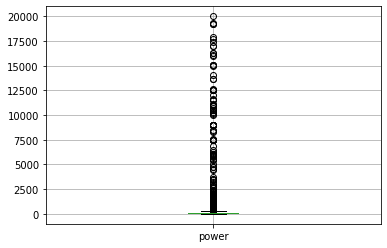

In [19]:
data.boxplot('power')

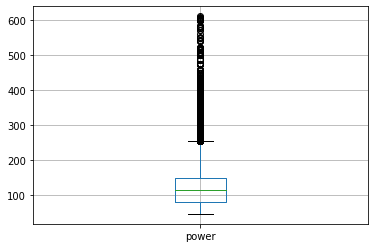

In [20]:
Q1 =  data['power'].quantile(0.12) #данный квантили подгонялись что бы не удалить редкие мощные машины 
Q3 = data['power'].quantile(0.999)
data = data[(data['power'] > Q1) & (data['power'] < Q3)]
data.boxplot('power')

In [21]:
data['vehicletype'].value_counts()

sedan          82682
small          66361
wagon          59162
bus            26175
convertible    18502
coupe          14433
suv            10917
other           2372
Name: vehicletype, dtype: int64

и по такому же принципу поступим с пропусками в столбце с типом кузова

In [22]:
data['vehicletype'] = data['vehicletype'].fillna('other')

In [23]:
data.isna().sum()

price          0
vehicletype    0
gearbox        0
power          0
model          0
kilometer      0
fueltype       0
brand          0
notrepaired    0
dtype: int64

все пропуски обработаны

In [24]:
data.head(15)

,price,vehicletype,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1,18300,coupe,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,manual,125,c_max,30000,petrol,ford,no
9,999,small,manual,101,golf,150000,other,volkswagen,no
10,2000,sedan,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,manual,140,passat,150000,gasoline,volkswagen,yes


In [25]:
data.columns

Index(['price', 'vehicletype', 'gearbox', 'power', 'model', 'kilometer',
       'fueltype', 'brand', 'notrepaired'],
      dtype='object')

In [26]:
data_col = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired'] #выделим категориальные переменные

In [27]:
data_col

['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

## Обучение моделей

In [28]:
mse = mean_squared_error 
label = LabelEncoder() 

In [29]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop('price', axis=1), data.price, test_size=0.25, random_state=12345) # разбиваем на обучающую и тестовую


In [30]:
features_train = features_train
features_test = features_test


In [31]:
for column in data_col:
    features_train[column] = label.fit_transform(features_train[column]) #Трансформируем таблицу
    features_test[column] = label.fit_transform(features_test[column])

In [32]:
param = {'iterations': [40, 60], 'depth': [d for d in range(2, 11)]} #зададим параметр для подбора
cv = KFold(n_splits=3, shuffle=True, random_state=12345)

### CatBoostRegressor LabelEncoder

In [33]:
cat = CatBoostRegressor(random_seed=12345)
grid_cat = GridSearchCV(cat, param, cv=cv)
# подбираем параметры 

In [34]:
%%time
grid_cat.fit(features_train, target_train)

0:	learn: 4556.4616781	total: 57.7ms	remaining: 2.25s
1:	learn: 4508.8223663	total: 146ms	remaining: 2.78s
2:	learn: 4462.7118950	total: 152ms	remaining: 1.87s
3:	learn: 4419.2442694	total: 245ms	remaining: 2.21s
4:	learn: 4377.3174539	total: 251ms	remaining: 1.75s
5:	learn: 4337.4981298	total: 344ms	remaining: 1.95s
6:	learn: 4299.8356078	total: 350ms	remaining: 1.65s
7:	learn: 4265.2187024	total: 443ms	remaining: 1.77s
8:	learn: 4230.5295043	total: 448ms	remaining: 1.54s
9:	learn: 4198.4959213	total: 542ms	remaining: 1.63s
10:	learn: 4163.6404943	total: 550ms	remaining: 1.45s
11:	learn: 4130.5712312	total: 641ms	remaining: 1.5s
12:	learn: 4101.1411040	total: 646ms	remaining: 1.34s
13:	learn: 4071.2270445	total: 740ms	remaining: 1.37s
14:	learn: 4044.2955258	total: 745ms	remaining: 1.24s
15:	learn: 4018.6133418	total: 838ms	remaining: 1.26s
16:	learn: 3991.5845825	total: 843ms	remaining: 1.14s
17:	learn: 3964.8486679	total: 937ms	remaining: 1.14s
18:	learn: 3941.7269679	total: 942ms	r

GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f11fcac6790>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'iterations': [40, 60]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [35]:
grid_cat.best_params_ # посмотрим на лучшее показатели

{'depth': 10, 'iterations': 60}

In [36]:
%%time
time_cat_fit = time.time()
cat = CatBoostRegressor(iterations=60, depth=10, cat_features=features_train, verbose=10) 
cat.fit(features_train, target_train) # обучим модель и посмотрим на время обучения
time_cat_fit = time.time() - time_cat_fit

0:	learn: 4534.6737634	total: 336ms	remaining: 19.8s
10:	learn: 3953.8474593	total: 3.92s	remaining: 17.5s
20:	learn: 3526.8592517	total: 7.41s	remaining: 13.8s
30:	learn: 3243.7425644	total: 11.1s	remaining: 10.4s
40:	learn: 3058.4820810	total: 14.5s	remaining: 6.72s
50:	learn: 2929.9456021	total: 18s	remaining: 3.17s
59:	learn: 2836.0910439	total: 21.1s	remaining: 0us
CPU times: user 19.8 s, sys: 2.03 s, total: 21.9 s
Wall time: 22.6 s


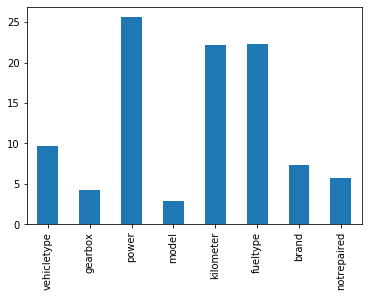

In [37]:
test = cat.feature_importances_
tost = pd.Series(test, index=features_train.columns)
tost.plot.bar(label='cat_feat')

In [38]:
%%time
time_cat_pred = time.time()
cat_pred = cat.predict(features_test)  # посмотрим на время предсказания
time_cat_pred = time.time() - time_cat_pred

CPU times: user 201 ms, sys: 24.4 ms, total: 225 ms
Wall time: 229 ms


In [39]:
rmse_cat = mse(target_test, cat_pred)**(.5)
print("RMSE на тесте: ", rmse_cat)

RMSE на тесте:  2971.005027943264


### LGBMRegressor

по тойже самой схеме пройдемся по данной модели

In [40]:
params = {
    'n_estimators': [40, 60],
    'num_leaves': [31, 41, 51],
}
lgbm = LGBMRegressor(random_state=12345)
grid_lgbm = GridSearchCV(lgbm, param, cv=cv)

In [41]:
%%time
grid_lgbm.fit(features_train, target_train)

CPU times: user 4min 58s, sys: 0 ns, total: 4min 58s
Wall time: 4min 59s


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=12345,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'iterations': [40

In [42]:
grid_lgbm.best_params_

{'depth': 2, 'iterations': 40}

In [43]:
%%time
time_lgbm_fit = time.time()
lgbm = LGBMRegressor(iterations=40, depth=2, silent=True)
lgbm.fit(features_train, target_train)
time_lgbm_fit = time.time() - time_lgbm_fit

CPU times: user 6.3 s, sys: 0 ns, total: 6.3 s
Wall time: 6.3 s


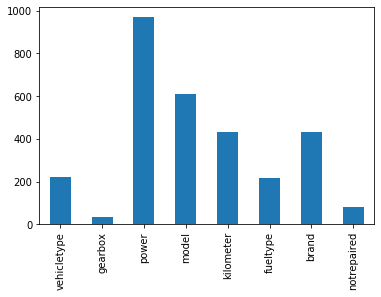

In [44]:
test = lgbm.feature_importances_
tost = pd.Series(test, index=features_train.columns)
tost.plot.bar(label='lgbm_feat')

In [45]:
%%time
time_lgbm_pred = time.time()
lgbm_pred = lgbm.predict(features_test)
time_lgbm_pred = time.time() - time_lgbm_pred

CPU times: user 511 ms, sys: 0 ns, total: 511 ms
Wall time: 466 ms


In [46]:
rmse_lgbm = mse(target_test, lgbm_pred)**(.5)
print("RMSE на тесте: ", rmse_lgbm)

RMSE на тесте:  2443.7080248206958


### LinearRegression

In [47]:
%%time

lr = LinearRegression(normalize=True)
time_lr_fit = time.time()
lr.fit(features_train, target_train)
time_lr_fit = time.time() - time_lr_fit

CPU times: user 60.6 ms, sys: 0 ns, total: 60.6 ms
Wall time: 43.3 ms


In [48]:
%%time
time_lr_pred = time.time()
lr_pred = lr.predict(features_test)
time_lr_pred = time.time() - time_lr_pred

CPU times: user 9.42 ms, sys: 0 ns, total: 9.42 ms
Wall time: 3.22 ms


In [49]:
rmse_lr = mse(target_test, lr_pred)**(.5)
print("RMSE на тесте: ", rmse_lr)

RMSE на тесте:  3152.067968036114


## Анализ моделей

создадим таблицу с показателями

In [50]:
df = [[time_cat_fit, time_cat_pred, rmse_cat],
      [time_lgbm_fit, time_lgbm_pred, rmse_lgbm],
      [time_lr_fit, time_lr_pred, rmse_lr]]
model = ["Catboost", "LGBM", "Linear"]

In [51]:
pd.DataFrame(data=df, index=model, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
Catboost,22.565367,0.229306,2971.005028
LGBM,6.301596,0.465906,2443.708025
Linear,0.043287,0.003191,3152.067968


## Вывод

Наилучшим качеством обладает модель LGBM, В то же время линейная регрессия обладает более высокой скоростью обучения и предсказания, но качество модели ниже, catboost самая медленная по обучению , качество и время предсказания среднее из группы, 